In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [86]:
def createGreenTaxiDataset(year):
  dfs = []
  for i in range(1,13):
    df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_{year}-{str(i).zfill(2)}.parquet')
    dfs.append(df)
  
  return pd.concat(dfs)

In [87]:
df = createGreenTaxiDataset(2021)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration_minutes
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667


LinearRegression()

/var/folders/87/zcq_b8352pg1_6l13vsrjj480000gn/T/ipykernel_14332/3273082551.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/87/zcq_b8352pg1_6l13vsrjj480000gn/T/ipykernel_14332/3273082551.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, labe

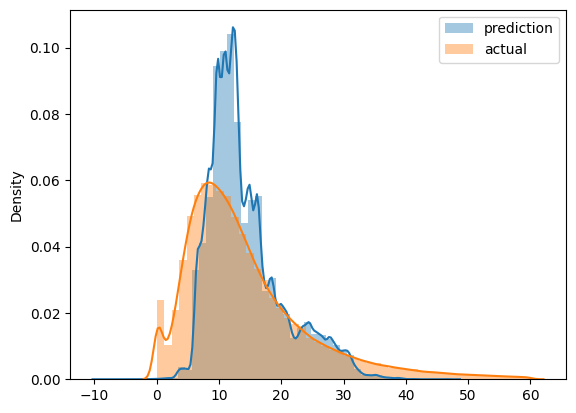

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.004520920466742